In [105]:
import pysabr
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [106]:
def ln_vol_to_n_vol(ln_vol, f, K): # B64
    return ln_vol * (f-K)/(np.log(f/K)) * (1- (ln_vol ** 2) / 24)
    

In [107]:
# shift is absorbed
def data_gen_sabr(ranges, in_mode, out_mode):
    print(f'input mode: {in_mode}, output mode: {out_mode}')
    start = time.time()
    Ss = ranges['S']
    Ts = ranges['T']
    V_atms = ranges['V_atm']
    betas = ranges['Beta']
    rhos = ranges['Rho']
    volvols = ranges['Volvol']
    Ks = ranges['K']

    sabr_processes = [pysabr.Hagan2002LognormalSABR(S, 0, T, V_atm, beta, rho, volvol) if in_mode=='ln' \
                      else pysabr.Hagan2002NormalSABR(S, 0, T, V_atm, beta, rho, volvol) \
                      for S in Ss \
                      for T in Ts \
                      for V_atm in V_atms \
                      for beta in betas \
                      for rho in rhos \
                      for volvol in volvols
                     ]

    vols = np.reshape([sabr.lognormal_vol(k) if out_mode=='ln' else sabr.normal_vol(k) \
                       for sabr in sabr_processes \
                       for k in Ks], \
                       (Ss.shape[0], Ts.shape[0], V_atms.shape[0], betas.shape[0], rhos.shape[0], \
                        volvols.shape[0], Ks.shape[0])\
                     )

    end = time.time()
    print(f'compute vols time: {end - start}')
    names = ["S", "T", "V_atm", "Beta", "Rho", "Volvol", "K"]
    multiindex = pd.MultiIndex.from_product([ranges[name] for name in names],
                                            names=names
                                           )
    full_df = pd.DataFrame(vols.reshape((-1,1)), index=multiindex, columns=[f"{out_mode}_vol"])

    print(full_df.describe())
    print(full_df.loc[(full_df<0).values])
    print(full_df.iloc[:20])
    return full_df


In [108]:
def plot_vols(vols, ranges, names=('T', 'K')): # in the right order
    fig = plt.figure(figsize=(15,15))
    X, Y = np.meshgrid(ranges[names[0]], ranges[names[1]], indexing='ij')
    Z = vols.pivot(index=names[0], columns=names[1], values='ln_vol').values

    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0,
                            antialiased=False)
    ax.set_zlim(np.min(vols['ln_vol'])*1.1, np.max(vols['ln_vol'])*1.1)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()
    # X, Y = np.meshgrid(ranges[axes[0]], ranges[axes[0]], indexing='ij')
    # print(X.shape)
    # print(Y.shape)
    # for beta_i in range(ranges['betas'].shape[0]):
    #     surface = vols[:, :, beta_i]
    #     print(surface.shape)
    #     ax = fig.add_subplot(1, ranges['betas'].shape[0], beta_i+1, projection='3d')
    #     surf = ax.plot_surface(X, Y, Z=surface, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0,
    #                             antialiased=False)
    #     ax.set_zlim(np.min(surface)*1.1, np.max(surface)*1.1)
    #     ax.set_title(f"beta: {ranges['betas'][beta_i]}")
    #     fig.colorbar(surf, shrink=0.5, aspect=10)
    # plt.show()

In [109]:
# data generation for training:
data_ranges = {'S': np.linspace(0.005+0.0, 0.07+0.03, num=12), # included displacement
               'T': np.linspace(0.5, 20., num=5), # 1 yr each
               'V_atm': np.linspace(0.001, 0.015, num=3), # inc = 0.001
               'Beta': np.linspace(0.1, 0.7, num=2),
               'Rho': np.linspace(-0.4, 0.4, num=3),
               'Volvol': np.linspace(0.0001, 0.5, num=5), # inc = 0.1
               'K': np.linspace(0.005+0.0, 0.07+0.03, num=12)
              }

In [110]:
# ln_res = data_gen_sabr(data_ranges, 'ln', 'ln')
# data_path = "data/"
# np.save(f"{data_ranges['Ss'].shape[0]}_{data_ranges['Ks'].shape[0]}_sample_lognormal_vol.npy", ln_res)

In [111]:
# n_res = data_gen_sabr(data_ranges, 'n', 'ln')

In [112]:
# testing ranges:
Ks = np.array([0.035])
Ss = np.linspace(0.005, 0.07, num=12)
Ts = np.linspace(0.5, 20., num=10)

V_atm_n = np.array([0.001])
betas = np.array([0.1, 0.7])
rhos = np.array([0.4])
volvols = np.array([0.5])
ds = np.array([0.01])

In [113]:
# normal:
n_ranges = {'S': Ss,
             'T': Ts,
             'V_atm': V_atm_n,
             'Beta': betas,
             'Rho': rhos,
             'Volvol': volvols,
             'd': ds,             
             'K': Ks,
            }
    
# n_res = data_gen_sabr(n_ranges, 'n', 'ln')

input mode: n, output mode: ln
compute vols time: 0.7391510009765625
           ln_vol
count  240.000000
mean     0.067876
std      0.257706
min     -1.544700
25%      0.053149
50%      0.076246
75%      0.110345
max      0.606014
                                               ln_vol
S     T         V_atm Beta Rho Volvol K              
0.005 4.833333  0.001 0.7  0.4 0.5    0.035 -0.097264
      7.000000  0.001 0.1  0.4 0.5    0.035 -0.667405
                      0.7  0.4 0.5    0.035 -1.138158
      9.166667  0.001 0.1  0.4 0.5    0.035 -1.456881
      13.500000 0.001 0.7  0.4 0.5    0.035 -1.544700
      15.666667 0.001 0.1  0.4 0.5    0.035 -0.015648
                      0.7  0.4 0.5    0.035 -1.449726
      17.833333 0.001 0.1  0.4 0.5    0.035 -0.151224
                      0.7  0.4 0.5    0.035 -1.372845
      20.000000 0.001 0.7  0.4 0.5    0.035 -1.309007
                                               ln_vol
S     T         V_atm Beta Rho Volvol K              
0.005 0.50000

In [114]:
n_res = data_gen_sabr(n_ranges, 'ln', 'ln')
print(n_res)

input mode: ln, output mode: ln
compute vols time: 0.7775173187255859
           ln_vol
count  240.000000
mean     0.118808
std      0.105079
min      0.030264
25%      0.058314
50%      0.080306
75%      0.127085
max      0.515748
Empty DataFrame
Columns: [ln_vol]
Index: []
                                               ln_vol
S     T         V_atm Beta Rho Volvol K              
0.005 0.500000  0.001 0.1  0.4 0.5    0.035  0.303092
                      0.7  0.4 0.5    0.035  0.420668
      2.666667  0.001 0.1  0.4 0.5    0.035  0.310209
                      0.7  0.4 0.5    0.035  0.431808
      4.833333  0.001 0.1  0.4 0.5    0.035  0.317321
                      0.7  0.4 0.5    0.035  0.442759
      7.000000  0.001 0.1  0.4 0.5    0.035  0.324426
                      0.7  0.4 0.5    0.035  0.453547
      9.166667  0.001 0.1  0.4 0.5    0.035  0.331522
                      0.7  0.4 0.5    0.035  0.464190
      11.333333 0.001 0.1  0.4 0.5    0.035  0.338608
                      

         S          T    ln_vol
0    0.005   0.500000  0.420668
1    0.005   2.666667  0.431808
2    0.005   4.833333  0.442759
3    0.005   7.000000  0.453547
4    0.005   9.166667  0.464190
..     ...        ...       ...
115  0.070  11.333333  0.092259
116  0.070  13.500000  0.094367
117  0.070  15.666667  0.096462
118  0.070  17.833333  0.098546
119  0.070  20.000000  0.100619

[120 rows x 3 columns]


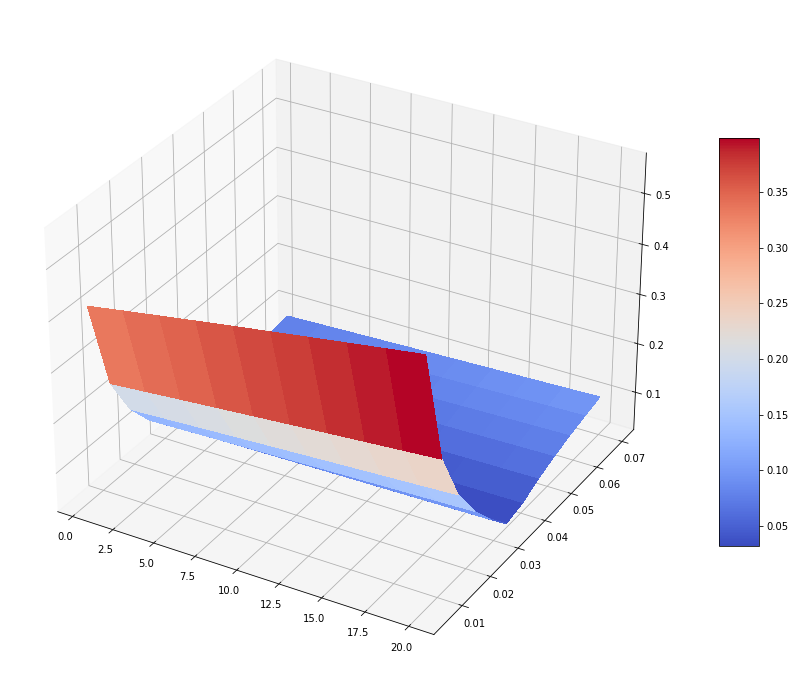

In [115]:
# normal:
data_in = n_res.loc[:,:,V_atm_n[0],betas[1],rhos[0],volvols[0]]
data_in = data_in.reset_index((2,3,4,5, 6), drop=True).reset_index()
print(data_in)

plot_vols(data_in, n_ranges, names=('T', 'S'))

In [116]:
sabr = pysabr.Hagan2002LognormalSABR(0.028636, .500000, 0.001, 0.7, -0.4, 0.5)
print(sabr.lognormal_vol(0.035))

1.3131943096771261
